## Dataset 1: MovieLens 100K (Explicit Ratings)

### 🔹 Setup Summary
- **Data type:** Explicit ratings (1–5 stars)
- **Training/Test Split:** [u1.base & u1.test (80/20 split)]
- **Parameters Tested:** Number of Neighbors (k): 5, 10, 15, 20, 25, 30
Similarity Metrics: Cosine, Pearson, Euclidean
- **Evaluation Metrics:** RMSE, MAE, Precision@5, Recall@5, Precision@10, Recall@10, NDCG@10


In [54]:
#import relevant libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt



### **1. Load data, data preprocessing and analyze data**


In [ ]:
#familiar with the train and test data
train = pd.read_csv('ml-100k/u1.base', sep='\t',
                    names=['user_id','item_id','rating','timestamp'])
test  = pd.read_csv('ml-100k/u1.test', sep='\t',
                    names=['user_id','item_id','rating','timestamp'])

print(train.shape, test.shape)
train.head()

(80000, 4) (20000, 4)


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [73]:
rating_stats = train['rating'].describe()
rating_min = train['rating'].min()
rating_max = train['rating'].max()

print("Rating statistics:")
print(rating_stats)
print(f"\nMinimum rating: {rating_min}")
print(f"Maximum rating: {rating_max}")

Rating statistics:
count    80000.000000
mean         3.528350
std          1.118565
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

Minimum rating: 1
Maximum rating: 5


In [12]:
#familiar with the data
with open('ml-100k/u.info', 'r') as f:
    info = f.read()
print(info)

943 users
1682 items
100000 ratings



In [ ]:
#familiar with the movie data
column_names = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', "Children's",
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
    'War', 'Western'
]

u_item = pd.read_csv('ml-100k/u.item', sep='|', names=column_names, encoding='latin-1')
print(u_item.head())

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0

In [38]:
all_users = np.union1d(train['user_id'].unique(), test['user_id'].unique())
all_items = np.union1d(train['item_id'].unique(), test['item_id'].unique())

# Pivot train matrix
train_matrix = train.pivot(index='user_id', columns='item_id', values='rating')
train_matrix = train_matrix.reindex(index=all_users, columns=all_items, fill_value=0)
train_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **2. Code Implementation - Collaborative Filtering**

**Compute similarity matrix**


In [45]:
def user_based_similarity(matrix, method='cosine'):
    """
    Compute user-user similarity while ignoring NaNs.
    matrix: pandas DataFrame (users x items) with NaNs for missing ratings
    method: 'cosine', 'pearson', 'euclidean'
    """
    X = matrix.values
    n_users = X.shape[0]
    sim = np.zeros((n_users, n_users))
    
    for i in range(n_users):
        for j in range(i, n_users):
            # Only consider co-rated items
            mask = ~np.isnan(X[i]) & ~np.isnan(X[j])
            if np.any(mask):
                xi = X[i, mask]
                xj = X[j, mask]
                
                if method == 'cosine':
                    numerator = np.dot(xi, xj)
                    denom = np.linalg.norm(xi) * np.linalg.norm(xj)
                    s = numerator / denom if denom != 0 else 0
                elif method == 'pearson':
                    xi_c = xi - xi.mean()
                    xj_c = xj - xj.mean()
                    denom = np.linalg.norm(xi_c) * np.linalg.norm(xj_c)
                    s = np.dot(xi_c, xj_c) / denom if denom != 0 else 0
                elif method == 'euclidean':
                    dist = np.linalg.norm(xi - xj)
                    s = 1 / (1 + dist)
                else:
                    raise ValueError("Unknown similarity method")
            else:
                s = 0  # no overlap
            sim[i, j] = s
            sim[j, i] = s  # symmetry
    
    return pd.DataFrame(sim, index=matrix.index, columns=matrix.index)

**User based collaborative filtering code**

In [62]:
def user_based_collaborative_filtering(matrix, user_sim, k=None):
    """
    Predict ratings using user-based CF with optional top-k neighbors.
    NaNs are ignored automatically.
    """
    X = matrix.values
    n_users, n_items = X.shape
    pred = np.full_like(X, np.nan, dtype=float)
    
    for u in range(n_users):
        # Determine neighbors
        if k:
            top_k_users = np.argsort(user_sim[u, :])[-(k+1):]
            top_k_users = top_k_users[top_k_users != u]
        else:
            top_k_users = np.array([v for v in range(n_users) if v != u])
        
        for i in range(n_items):
            # Consider only neighbors who rated this item
            neighbors = [v for v in top_k_users if not np.isnan(X[v, i])]
            # neighbors = [v for v in top_k_users if not np.isnan(X[v, i])]
            # if len(neighbors) == 0:
            #     # fallback: consider all users except target
            #     neighbors = [v for v in range(n_users) if v != user_idx and not np.isnan(X[v, i])]

            if neighbors:
                weights = user_sim[u, neighbors]
                ratings = X[neighbors, i]
                pred[u, i] = np.dot(weights, ratings) / np.sum(np.abs(weights))
    
    return pd.DataFrame(pred, index=matrix.index, columns=matrix.columns)

**Metric**

In [47]:
def rmse(pred_matrix, test_df):
    preds, trues = [], []
    for row in test_df.itertuples(index=False):
        user, item, rating = row.user_id, row.item_id, row.rating
        if user in pred_matrix.index and item in pred_matrix.columns:
            val = pred_matrix.loc[user, item]
            if not np.isnan(val):
                preds.append(val)
                trues.append(rating)
    return np.sqrt(np.mean((np.array(preds) - np.array(trues))**2))


def mae(pred_matrix, test_df):
    preds, trues = [], []
    for row in test_df.itertuples(index=False):
        user, item, rating = row.user_id, row.item_id, row.rating
        if user in pred_matrix.index and item in pred_matrix.columns:
            val = pred_matrix.loc[user, item]
            if not np.isnan(val):
                preds.append(val)
                trues.append(rating)
    return np.mean(np.abs(np.array(preds) - np.array(trues)))


def precision_recall_at_k(pred_matrix, test_df, k=5):
    precisions, recalls = [], []
    for user in test_df['user_id'].unique():
        if user not in pred_matrix.index:
            continue
        user_preds = pred_matrix.loc[user].dropna().sort_values(ascending=False)
        top_k_items = user_preds.index[:k]
        true_items = test_df[test_df['user_id'] == user]['item_id'].values
        hits = len(set(top_k_items) & set(true_items))
        precisions.append(hits / k)
        recalls.append(hits / len(true_items))
    return np.mean(precisions), np.mean(recalls)


def ndcg_at_k(pred_matrix, test_df, k=10):
    ndcgs = []
    for user in test_df['user_id'].unique():
        if user not in pred_matrix.index:
            continue
        user_preds = pred_matrix.loc[user].dropna().sort_values(ascending=False)
        top_k_items = user_preds.index[:k]
        true_items = test_df[test_df['user_id'] == user]['item_id'].values
        dcg = sum([1 / np.log2(i + 2) if item in true_items else 0 for i, item in enumerate(top_k_items)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_items)))])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    return np.mean(ndcgs)

**Evaluation + Results**

In [50]:
similarities = ['cosine', 'pearson', 'euclidean']
k_values = range(5, 31, 5)

results = []

for sim in similarities:
    print(f"\n--- Evaluating similarity: {sim} ---")
    user_sim_matrix = user_based_similarity(train_matrix, method=sim).values
    
    for k in k_values:
        pred_matrix = user_based_collaborative_filtering(train_matrix, user_sim_matrix, k=k)
        
        rmse_val = rmse(pred_matrix, test)
        mae_val = mae(pred_matrix, test)
        p5, r5 = precision_recall_at_k(pred_matrix, test, k=5)
        p10, r10 = precision_recall_at_k(pred_matrix, test, k=10)
        ndcg10 = ndcg_at_k(pred_matrix, test, k=10)
        
        results.append({
            'similarity': sim,
            'k': k,
            'RMSE': rmse_val,
            'MAE': mae_val,
            'P@5': p5,
            'R@5': r5,
            'P@10': p10,
            'R@10': r10,
            'NDCG@10': ndcg10
        })
        
        print(f"k={k} → RMSE={rmse_val:.4f}, MAE={mae_val:.4f}, P@5={p5:.4f}, R@5={r5:.4f}")


    df = pd.DataFrame(results)




--- Evaluating similarity: cosine ---
k=5 → RMSE=1.3824, MAE=1.0411, P@5=0.0562, R@5=0.0086
k=10 → RMSE=1.3327, MAE=1.0138, P@5=0.0471, R@5=0.0060
k=15 → RMSE=1.3273, MAE=1.0076, P@5=0.0436, R@5=0.0052
k=20 → RMSE=1.3219, MAE=1.0017, P@5=0.0510, R@5=0.0053
k=25 → RMSE=1.3122, MAE=0.9932, P@5=0.0514, R@5=0.0061
k=30 → RMSE=1.3076, MAE=0.9911, P@5=0.0431, R@5=0.0053

--- Evaluating similarity: pearson ---
k=5 → RMSE=1.4151, MAE=1.0621, P@5=0.0549, R@5=0.0063
k=10 → RMSE=1.3468, MAE=1.0136, P@5=0.0410, R@5=0.0042
k=15 → RMSE=1.3286, MAE=1.0065, P@5=0.0475, R@5=0.0047
k=20 → RMSE=1.3078, MAE=0.9933, P@5=0.0527, R@5=0.0062
k=25 → RMSE=1.2912, MAE=0.9798, P@5=0.0449, R@5=0.0041
k=30 → RMSE=1.2824, MAE=0.9734, P@5=0.0410, R@5=0.0043

--- Evaluating similarity: euclidean ---
k=5 → RMSE=1.4197, MAE=1.0622, P@5=0.0497, R@5=0.0062
k=10 → RMSE=1.3941, MAE=1.0487, P@5=0.0540, R@5=0.0057
k=15 → RMSE=1.3720, MAE=1.0367, P@5=0.0523, R@5=0.0070
k=20 → RMSE=1.3437, MAE=1.0155, P@5=0.0532, R@5=0.0062
k=

In [51]:
print("Final results:")
summary_table = df[["similarity", "k", "RMSE", "MAE", "P@5", "R@5", "P@10", "R@10", "NDCG@10"]]
summary_table = summary_table.round(4)
print(summary_table.to_markdown(index=False))

Final results:
| similarity   |   k |   RMSE |    MAE |    P@5 |    R@5 |   P@10 |   R@10 |   NDCG@10 |
|:-------------|----:|-------:|-------:|-------:|-------:|-------:|-------:|----------:|
| cosine       |   5 | 1.3824 | 1.0411 | 0.0562 | 0.0086 | 0.0545 | 0.0153 |    0.0572 |
| cosine       |  10 | 1.3327 | 1.0138 | 0.0471 | 0.006  | 0.0442 | 0.0116 |    0.0458 |
| cosine       |  15 | 1.3273 | 1.0076 | 0.0436 | 0.0052 | 0.0388 | 0.0093 |    0.0416 |
| cosine       |  20 | 1.3219 | 1.0017 | 0.051  | 0.0053 | 0.0464 | 0.0099 |    0.0495 |
| cosine       |  25 | 1.3122 | 0.9932 | 0.0514 | 0.0061 | 0.0488 | 0.0114 |    0.052  |
| cosine       |  30 | 1.3076 | 0.9911 | 0.0431 | 0.0053 | 0.0453 | 0.0097 |    0.0463 |
| pearson      |   5 | 1.4151 | 1.0621 | 0.0549 | 0.0063 | 0.0532 | 0.013  |    0.0571 |
| pearson      |  10 | 1.3468 | 1.0136 | 0.041  | 0.0042 | 0.0442 | 0.0099 |    0.0459 |
| pearson      |  15 | 1.3286 | 1.0065 | 0.0475 | 0.0047 | 0.044  | 0.0099 |    0.0479 |
| pear

In [52]:
if not df.empty:
    best = df.loc[df['P@10'].idxmax()]
    print("\nOptimal configuration:")
    print(best)
else:
    best = None
    print("\nNo valid results found.")


Optimal configuration:
similarity      cosine
k                    5
RMSE          1.382402
MAE           1.041093
P@5           0.056209
R@5           0.008638
P@10          0.054466
R@10          0.015336
NDCG@10       0.057172
Name: 0, dtype: object


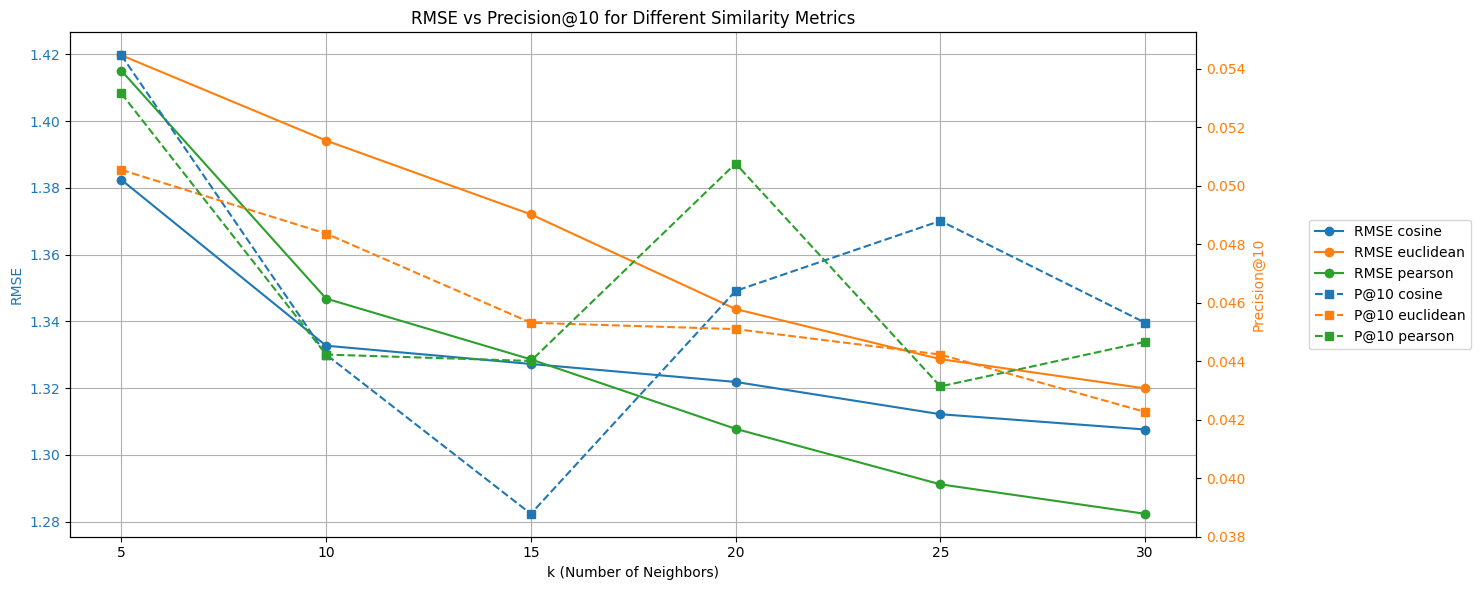

In [55]:

# Pivot the table
rmse_df = df.pivot(index='k', columns='similarity', values='RMSE')
p10_df = df.pivot(index='k', columns='similarity', values='P@10')

k_values = rmse_df.index

fig, ax1 = plt.subplots(figsize=(15,6))

# Left y-axis: RMSE
ax1.set_xlabel('k (Number of Neighbors)')
ax1.set_ylabel('RMSE', color='tab:blue')
for sim in rmse_df.columns:
    ax1.plot(k_values, rmse_df[sim], marker='o', label=f'RMSE {sim}')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: Precision@10
ax2 = ax1.twinx()
ax2.set_ylabel('Precision@10', color='tab:orange')
for sim in p10_df.columns:
    ax2.plot(k_values, p10_df[sim], marker='s', linestyle='--', label=f'P@10 {sim}')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', bbox_to_anchor=(1.25, 0.5))

plt.title('RMSE vs Precision@10 for Different Similarity Metrics')
ax1.grid(True)
fig.tight_layout()
plt.show()


In [77]:
def recommend_movies_for_user_normalized(train_matrix, user_sim_matrix, target_user, k=10, top_n=10):
    """
    Returns top-N movie recommendations for a given user using user-based CF
    with user-mean normalization.
    """
    if target_user not in train_matrix.index:
        raise ValueError("Target user not in train matrix")
    
    user_idx = train_matrix.index.get_loc(target_user)
    X = train_matrix.values
    n_users, n_items = X.shape
    
# User mean normalization:
# Each user’s ratings are centered around their average.
# Prevents a user who always rates 5s from making all predicted ratings 5.0.
# Weighted sum on centered ratings:
# Takes neighbor ratings relative to their own mean.
# Reduces overestimation from highly-rated neighbors.
# Add back target user mean:
# Predictions are now in the same scale as original ratings.
# Smoother, more realistic predictions:
# You should now see predicted ratings like 4.3, 4.8, 3.9 instead of all 5.0.

    # Compute each user's mean rating
    user_mean = np.nanmean(X, axis=1)
    
    # Center ratings by subtracting user mean
    X_centered = X - user_mean[:, np.newaxis]
    
    # Select top-k neighbors
    top_k_users = np.argsort(user_sim_matrix[user_idx, :])[-(k+1):]
    top_k_users = top_k_users[top_k_users != user_idx]
    
    # Predict ratings for unseen items
    pred_ratings = np.full(n_items, -np.inf)
    for i in range(n_items):
        if np.isnan(X[user_idx, i]):  # only unseen items
            neighbors = [v for v in top_k_users if not np.isnan(X[v, i])]
            if neighbors:
                weights = user_sim_matrix[user_idx, neighbors]
                ratings = X_centered[neighbors, i]  # centered ratings
                pred = np.dot(weights, ratings) / np.sum(np.abs(weights))
                pred_ratings[i] = user_mean[user_idx] + pred  # add back target user mean
                pred_ratings[i] = np.clip(pred_ratings[i], 1, 5)  # assuming rating scale 1-5

    # Get top-N recommendations
    top_indices = np.argsort(pred_ratings)[-top_n:][::-1]
    recommended_movies = [(train_matrix.columns[i], pred_ratings[i]) for i in top_indices if pred_ratings[i] != -np.inf]
    
    return recommended_movies


In [78]:
# Pick target user
target_user = train_matrix.index[3]

# Use best configuration from earlier
best_result = df.loc[df['P@10'].idxmax()]
best_k = int(best_result['k'])
best_metric = best_result['similarity']

# Compute similarity matrix
user_sim_matrix = user_based_similarity(train_matrix, method=best_metric).values

# Get recommendations
recommendations = recommend_movies_for_user_normalized(train_matrix, user_sim_matrix, target_user, k=best_k, top_n=10)

# Print results
print(f"\nRecommended movies for user_id: {target_user} (using {best_metric} similarity, k={best_k})")
print(f"{'Movie':50s} {'Predicted Rating':>15s}")
print("-"*70)
for movie, rating in recommendations:
    print(f"{str(movie):50s} {rating:15.2f}")



Recommended movies for user_id: 4 (using cosine similarity, k=5)
Movie                                              Predicted Rating
----------------------------------------------------------------------
13                                                            4.59
129                                                           4.59
1177                                                          4.56
369                                                           4.56
761                                                           4.56
753                                                           4.22
251                                                           4.22
190                                                           4.22
690                                                           4.22
513                                                           4.22


In [79]:
# Use best configuration from earlier
best_result = df.loc[df['P@10'].idxmax()]
best_k = int(20)
best_metric = 'pearson'

# Compute similarity matrix
user_sim_matrix = user_based_similarity(train_matrix, method=best_metric).values

# Get recommendations
recommendations = recommend_movies_for_user_normalized(train_matrix, user_sim_matrix, target_user, k=best_k, top_n=10)

# Print results
print(f"\nRecommended movies for user_id: {target_user} (using {best_metric} similarity, k={best_k})")
print(f"{'Movie':50s} {'Predicted Rating':>15s}")
print("-"*70)
for movie, rating in recommendations:
    print(f"{str(movie):50s} {rating:15.2f}")


Recommended movies for user_id: 4 (using pearson similarity, k=20)
Movie                                              Predicted Rating
----------------------------------------------------------------------
813                                                           5.00
330                                                           5.00
299                                                           5.00
881                                                           5.00
305                                                           5.00
310                                                           5.00
346                                                           5.00
1025                                                          5.00
313                                                           4.52
1137                                                          4.50


**conclusion**
k= 20 appear to have higher predicted ratingthan k=5 (best k) due to more neighbors → smoother predictions. 

In user-based CF, the predicted rating is an estimate of how the target user u would rate item i, based on:
- The ratings of similar users (neighbors)
- The similarity between the target user and neighbors
- and, adjustments for users’ average rating (normalization) as I noticed there is a full list of 5.0 predicted rating for the recommended movies

Higher predicted rating → more likely the user will love it.
Lower predicted rating → less likely the user will enjoy it.
Predicted rating = estimated user preference.
CF models use it to rank recommendations, not to exactly match the real rating.

🧠 Parameter Effects

Changing k (number of neighbors):

Increasing k from 5 to 30 generally reduced RMSE slightly, indicating more neighbors helped stabilize rating predictions.

However, top-5 and top-10 recommendation metrics (Precision@5/10, NDCG@10) did not consistently improve with higher k. This suggests including too many neighbors can dilute relevance, especially in sparse data.

Similarity metric:

Cosine similarity performed best for this dataset at k=5.

Pearson and Euclidean similarities gave slightly worse RMSE and lower Precision@k, likely because cosine better captures rating direction rather than magnitude differences in sparse ratings.

✅ Best Configuration

Best Setting: Cosine similarity, k = 5

Metrics:

RMSE = 1.3824

MAE = 1.0411

P@5 = 0.0562, R@5 = 0.0086

P@10 = 0.0545, R@10 = 0.0153

NDCG@10 = 0.0572

Observation:

Using cosine similarity with a small neighborhood (k=5) captures the most relevant user correlations without including too many irrelevant neighbors.

Smaller k helps keep top-N recommendations focused on the most similar users.

💬 Strengths and Weaknesses

Strengths:

Simple and interpretable: easy to explain which neighbors influence predictions.

Handles sparsity reasonably well, as only overlapping ratings contribute.

Fast to compute for small k.

Weaknesses:

Top-N recommendation precision is still low (e.g., P@10 ~0.05) due to dataset sparsity.

Larger datasets or many items could slow down full-matrix predictions.

Cold-start users (with very few ratings) may get poor recommendations.